# Plotting figures for the paper "Attosecond electron microscopy by free-electron homodyne detection"

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib.colors import hsv_to_rgb

In [2]:
def complex_array_to_rgb(X, theme="dark", rmax=None, offset=0.6 * np.pi):
    """Takes an array of complex number and converts it to an array of [r, g, b],
    where phase gives hue and saturaton/value are given by the absolute value.
    Especially for use with imshow for complex plots.
    Based on: https://stackoverflow.com/a/17113417/22363132"""
    absmax = rmax or np.nanmax(np.abs(X))
    abs_intensity = np.clip(np.abs(X) / absmax, 0, 1)
    Y = np.zeros(X.shape + (3,), dtype="float")
    Y[..., 0] = (np.angle(X) + offset) / (2 * np.pi) % 1
    if theme == "light":
        Y[..., 1] = abs_intensity
        Y[..., 2] = 1
    elif theme == "dark":
        Y[..., 1] = 1
        Y[..., 2] = abs_intensity
    Y = hsv_to_rgb(Y)
    # Set NaNs to white
    Y[np.isnan(X), :] = [1, 1, 1]
    return Y

## Load data
- datasets are stored in HDF5-container saved as .mat files `'-v7.3'`

In [3]:
from dataclasses import dataclass


@dataclass
class DataInterferogram:
    data: np.ndarray
    px_size: float
    phase_v: np.ndarray
    amplitude: np.ndarray = None
    offset: np.ndarray = None
    phase_offset: np.ndarray = None
    file_path: Path = None


@dataclass
class Data:
    g: np.ndarray
    transmission: np.ndarray
    px_size: float
    spatial_filter: np.ndarray
    crop_rectangle: np.ndarray
    file_path: Path
    contour: np.ndarray = None
    phase_ref : float = None


@dataclass
class DataSet:
    interferogram: DataInterferogram
    g_map: Data


def read_g_total_from_file(file_path: Path) -> np.ndarray:
    with h5py.File(file_path, "r") as f:
        # print("Keys: %s" % f.keys())
        g_total = f["g_maps_corr"][()].transpose()
        px_size = f["px_size"][0]
        phase_v = f["phase"][()].flatten()
        # try to read amplitude and offset, if not possible, set to None
        try:
            amplitude = f["amplitude"][()].transpose()
            offset = f["offset"][()].transpose()
            phase_offset = f["phase_offset"][()].transpose()
        except KeyError:
            amplitude = None
            offset = None
            phase_offset = None
    data = DataInterferogram(
        data=g_total,
        px_size=px_size,
        phase_v=phase_v,
        amplitude=amplitude,
        offset=offset,
        phase_offset=phase_offset,
        file_path=file_path,
    )
    return data


def read_g_map_from_file(file_path: Path) -> Data:
    # read hdf5 file
    with h5py.File(file_path, "r") as f:
        # print("Keys: %s" % f.keys())
        g = f["complex"][()].transpose()
        # convert dtype real, imag into complex
        g = g["real"] + 1j * g["imag"]
        spatial_filter = f["spatial_filter"][()].transpose()
        transmission = f["transmission"][()].transpose()
        px_size = f["px_size"][0]
        crop_rectangle = f["crop_rectangle"][()].flatten().astype(int)
        # try to read contour, if not possible, set to None
        try:
            contour = f["contour"][()].transpose() - 1
        except KeyError:
            contour = None
        try:
            phase_ref = f["phase_ref"][0]
        except KeyError:
            phase_ref = None
        data = Data(
            g=g,
            transmission=transmission,
            px_size=px_size,
            spatial_filter=spatial_filter,
            crop_rectangle=crop_rectangle,
            file_path=file_path,
            contour=contour,
            phase_ref=phase_ref
        )
    return data

In [4]:
project_root = Path.cwd()
folder = project_root / "data/"
wavelength = 960e-9
data_sets = []
for ii, no in enumerate(["polarization_1", "polarization_2"]):
    file_path = folder / f"{no}_g_total.mat"
    interferogram = read_g_total_from_file(file_path)
    file_path = folder / f"{no}_results.mat"
    g_map = read_g_map_from_file(file_path)
    data_set = DataSet(interferogram=interferogram, g_map=g_map)
    data_sets.append(data_set)

In [5]:
def crop_data(M, crop_rectangle):
    return M[
        crop_rectangle[1] : crop_rectangle[1] + crop_rectangle[3],
        crop_rectangle[0] : crop_rectangle[0] + crop_rectangle[2],
    ]


data_set = data_sets[0]
cropping = lambda M: crop_data(M, data_set.g_map.crop_rectangle)


def sinusoid(phase, offset, amplitude, phase_offset):
    return offset + amplitude * np.cos(phase - phase_offset)

## Fig. 3: Recorded FREHD interferograms for an optically excited gold nanoprism.

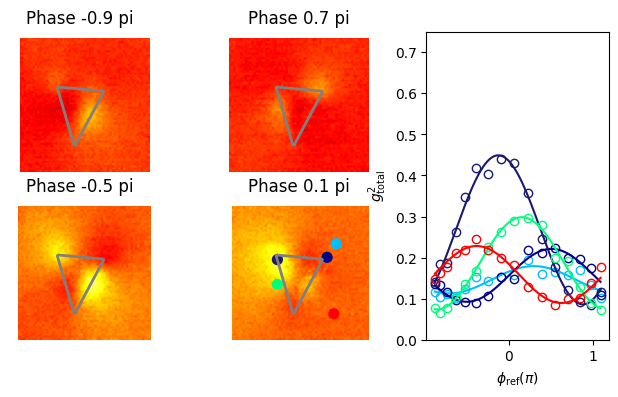

In [6]:
data_set = data_sets[0]
phase_zeroed = data_set.interferogram.phase_v - data_set.g_map.phase_ref
phase_vector = np.linspace(phase_zeroed.min(), phase_zeroed.max(), 2**8)
idxs = [0, 12, 4, 8]
contour = np.vstack([data_set.g_map.contour, data_set.g_map.contour[0]])
fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(2, 3)
axs = []
axs.append(fig.add_subplot(gs[0, 0]))
axs.append(fig.add_subplot(gs[0, 1]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[1, 1]))
ax2 = fig.add_subplot(gs[:, 2])


for ii, (ax, idx) in enumerate(zip(np.array(axs).flatten(), idxs)):
    ax.imshow(
        cropping(data_set.interferogram.data[:, :, idxs[ii]]),
        cmap="hot",
        vmin=0,
        vmax=0.8,
    )
    ax.title.set_text(f"Phase {(phase_zeroed[idx]/np.pi):.1f} pi")
    ax.axis("off")
    ax.plot(contour[:, 0], contour[:, 1], "gray", linewidth=2)


idxs = np.array([[63, 36], [59, 42], [37, 43], [37, 54], [62, 67]]) - 1
idxs_cropped = idxs - (data_sets[0].g_map.crop_rectangle[:2] - 1)
colors = ["deepskyblue", "darkblue", "midnightblue", "springgreen", "red"]
ax.scatter(idxs_cropped[:, 0], idxs_cropped[:, 1], c=colors, s=50, marker="o")

ax2.set_ylim(0, 0.75)
ax2.set_xlabel("$\phi_\mathrm{ref} (\pi)$")
ax2.set_ylabel("${g_\mathrm{total}^2}$")
for (col, row), color in zip(idxs, colors):
    ax2.plot(
        phase_zeroed / np.pi,
        data_set.interferogram.data[row, col, :] ** 2,
        "o",
        color=color,
        label=f"({row},{col})",
        markerfacecolor="none",
    )
    ax2.plot(
        phase_vector / np.pi,
        sinusoid(
            phase_vector,
            data_set.interferogram.offset[row, col],
            data_set.interferogram.amplitude[row, col],
            data_set.interferogram.phase_offset[row, col] - data_set.g_map.phase_ref,
        ),
        color=color,
    )

## Fig. 4: Measured electric field evolution at a gold nanoprism.

/srv/conda/envs/notebook/lib/python3.10/site-packages/matplotlib/colors.py:2149: RuntimeWarning: invalid value encountered in cast
  i = (h * 6.0).astype(int)


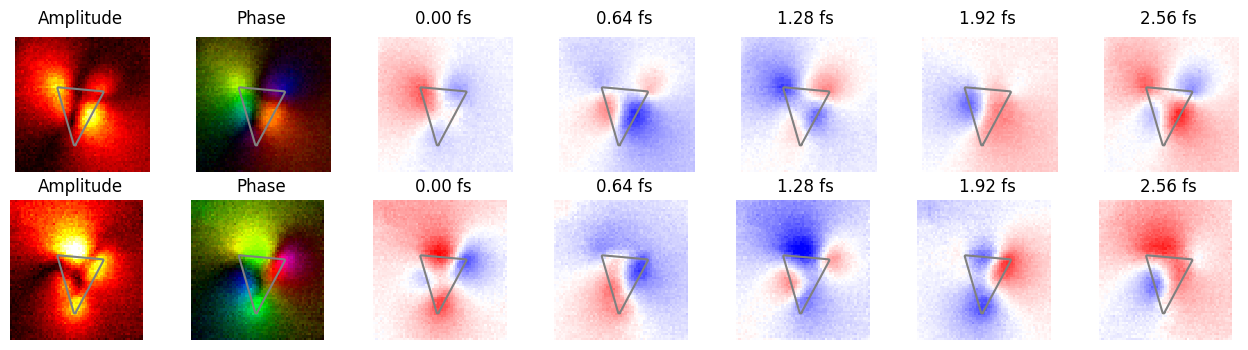

In [7]:
n_phases = 5
fig, axs = plt.subplots(2, 2 + n_phases , figsize=(16, 4))
vmax = 0.4
row = 0
for row, data_set in enumerate(data_sets):
    axs[row, 0].imshow(
        cropping(np.abs(data_set.g_map.g)), cmap="hot", vmax=vmax, interpolation="none"
    )
    axs[row, 0].set_title("Amplitude")
    # ax[1].imshow(cropping(np.angle(data)))
    axs[row, 1].imshow(
        complex_array_to_rgb(cropping(data_set.g_map.g), rmax=0.3, offset=0.65 * np.pi),
        interpolation="none",
    )
    axs[row, 1].set_title("Phase")
    phases = np.linspace(0, 2 * np.pi, n_phases, endpoint=False)
    for ii, phase in enumerate(phases, start=2):
        axs[row, ii].imshow(
            np.real(cropping(data_set.g_map.g * np.exp(-1j * phase))),
            cmap="bwr",
            vmin=-vmax,
            vmax=vmax,
            interpolation="none",
        )
        axs[row, ii].set_title(f"{phase/(2*np.pi)*wavelength/3e8/1e-15:.2f} fs")
    # axis off
    if data_set.g_map.contour is not None:
        # append first point to close the contour
        contour = np.vstack([data_set.g_map.contour, data_set.g_map.contour[0]])
        for ax in axs[row, :]:
            ax.plot(contour[:, 0], contour[:, 1], "gray")
        # axs[row, 1].contour(data_set.g_map.contour, levels=[0.5], colors="white")
    for a in axs.flatten():
        a.axis("off")

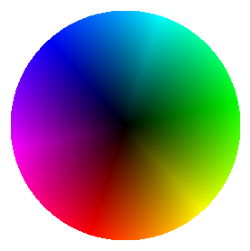

In [8]:
x_v = np.linspace(-1, 1, 2**8)
X, Y = np.meshgrid(x_v, x_v)
Z = X + 1j * Y
colorwheel = complex_array_to_rgb(Z, rmax=1)
colorwheel[abs(Z)>1,:] = [1,1,1]
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(colorwheel, extent=(-1, 1, -1, 1), origin="lower")
_ = ax.axis("off")